In [1]:
### import os
import csv
import numpy as np
import pandas as pd
import re
import pickle
import json
from tqdm import tqdm
import sys
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from PIL import Image

### Options

In [2]:
#output_path = r'C:\Users\natal\Desktop\Korpus\run_bote_201219'
#output_path = r'C:\Users\natal\Desktop\Korpus\run_magazin_210104'

#### simon's laptop ####

output_path = r'D:\Natalie\13_korpus\run_mag_210216'
analysis_path = r'D:\Natalie\14_analysis\kombi_lsb_in_SG_NB'#
output_path = r'D:\Natalie\13_korpus\run_bote_210216'

json_place = output_path + r"\\sents_w_info.json"
coords_list = output_path + r"\\coords_list.csv"
coords_list_by_uuid = output_path + r"\\coords_list_by_uuid.csv"

In [3]:
def list_to_df(coords_list):
    df = pd.read_csv(coords_list, sep=';', encoding='utf-8', usecols=['uuid','sen_id', 'lsb'])
    #print(df.columns)
    return df

In [36]:
with open(json_place, encoding='UTF-8') as json_file:
    all_data = json.load(json_file)
orig_data=all_data

        
nr_deleted = 0
nr_deleted_lsb = 0
nr_empty = 0

for i in range(len(all_data)):
        for j in range(len(all_data[i]['topo_infos'])-1, -1, -1):
            if all_data[i]['topo_infos'][j]['topo'] in ["Alp","Au","Bauernhof","Berg","Tal","Dorf","Fall","Land","Platz",
                                                          "Felsen","Ort","Sonne","Länder","Kreuz","Gross","Hand",
                                                          "Paradies","Peter","Post","Port","Quai","Steg","Stein",
                                                          "Stock","Strich","Waldhütte","Tisch","Wurf","Blatt","Bad",
                                                          "Badi","Löwen","Gisler","Suter","Vogler","Vogt","Holz",
                                                          "Adelboden","Albis","Saas","Wallis","Zug"]:
                all_data[i]['topo_infos'].pop(j)
                nr_deleted += 1
        for j in range(len(all_data[i]['lsb'])-1, -1, -1):
            if all_data[i]['lsb'][j]['ls-wort'] in ["Weg", "Wetter", "Sattel", "Terrasse", "Tierpark", "Haus", "Restaurant"]:
                all_data[i]['lsb'].pop(j)
                nr_deleted_lsb += 1
                
print("nr deleted topos: ", nr_deleted)
print("nr deleted lsb: ", nr_deleted_lsb)

# Testen: wieviele Sätze bleiben noch 
for i in range(len(all_data)-1, -1, -1):
    if len(all_data[i]['topo_infos'])==0 or len(all_data[i]['lsb'])==0:
        nr_empty+=1
        all_data.pop(i)


nr deleted topos:  123
nr deleted lsb:  19


# durchschnittliche topos und infos pro satz

In [37]:
num_topos = []
num_instances = []
obj_ids = []
num_lsbs = []

for obj in all_data:
    num_topos.append(len(obj["topo_infos"]))
    num_lsbs.append(len(obj["lsb"]))
    for topo_info in obj["topo_infos"]:
        num_instances.append(len(topo_info["info"]))
        obj_ids.append(obj["ID"])

print("TOPOS:")
print("mean:", np.mean(num_topos))
print("median:", np.median(num_topos))
m = stats.mode(num_topos)
print("mode:", m[0][0], f"({m[1][0]})")
print("max:", np.max(num_topos))

print()

print("INSTANCES (eindeutigkeit toponym):")
print("mean:", np.mean(num_instances))
print("median:", np.median(num_instances))
m = stats.mode(num_instances)
print("mode:", m[0][0], f"({m[1][0]})")
print("max:", np.max(num_instances))

print()

print("LSB:")
print("mean:", np.mean(num_lsbs))
print("median:", np.median(num_lsbs))
m = stats.mode(num_lsbs)
print("mode:", m[0][0], f"({m[1][0]})")
print("max:", np.max(num_lsbs))

TOPOS:
mean: 1.7363636363636363
median: 1.0
mode: 1 (116)
max: 7

INSTANCES (eindeutigkeit toponym):
mean: 2.3795811518324608
median: 2.0
mode: 1 (155)
max: 16

LSB:
mean: 1.6818181818181819
median: 1.0
mode: 1 (121)
max: 6


## konkrete sätze mit den max topos und instances

In [41]:
#highest topo counts in sen_id: 2149 und 4907 (bote -- 12 topos), 145 und 145 (magazin -- 7 topos)
#highest lsb counts in sen_id: 372 (bote -- 9 lsb), 116 und 186 (magazin -- 6 lsb)

senid_dict={}
processed_sentences = {}

for uuid, sen_id, lsb in zip(coords['uuid'], coords['sen_id'], coords['lsb']):
    if sen_id in processed_sentences:
        continue
    else:
        processed_sentences[sen_id] = True
        lsbs = re.split('\,',lsb)
        senid_dict[sen_id] = len(lsbs)

print(len(senid_dict))
max_len = 0
max_k = None
for k in sorted(senid_dict.keys()):
    print(k, senid_dict[k], ",")
    if max_len < senid_dict[k]:
        max_len = senid_dict[k]
        max_k = k
print(max_len, max_k)

220
1 1 ,
2 1 ,
3 2 ,
4 2 ,
5 2 ,
6 2 ,
7 3 ,
8 3 ,
9 1 ,
11 3 ,
12 1 ,
13 1 ,
14 3 ,
15 1 ,
16 1 ,
17 1 ,
18 2 ,
19 1 ,
20 1 ,
21 4 ,
22 2 ,
23 3 ,
24 2 ,
25 2 ,
26 2 ,
27 2 ,
28 1 ,
29 2 ,
30 1 ,
31 1 ,
32 2 ,
33 4 ,
34 3 ,
35 2 ,
36 1 ,
37 2 ,
39 2 ,
40 1 ,
41 2 ,
42 1 ,
43 1 ,
44 1 ,
45 1 ,
46 2 ,
47 2 ,
48 1 ,
49 2 ,
50 2 ,
51 2 ,
52 2 ,
53 1 ,
54 2 ,
56 1 ,
57 1 ,
58 1 ,
59 2 ,
61 1 ,
63 1 ,
64 1 ,
65 1 ,
66 4 ,
67 1 ,
68 2 ,
69 1 ,
70 2 ,
71 1 ,
72 1 ,
73 2 ,
74 1 ,
75 1 ,
78 2 ,
80 1 ,
81 1 ,
82 1 ,
83 1 ,
84 2 ,
85 1 ,
86 5 ,
87 1 ,
88 1 ,
90 1 ,
91 2 ,
92 1 ,
93 6 ,
94 1 ,
95 1 ,
96 1 ,
97 3 ,
98 3 ,
99 1 ,
100 5 ,
101 1 ,
102 1 ,
103 1 ,
105 1 ,
106 2 ,
107 1 ,
108 2 ,
109 2 ,
110 1 ,
112 1 ,
113 1 ,
114 2 ,
115 1 ,
116 1 ,
117 2 ,
118 1 ,
119 1 ,
120 1 ,
121 1 ,
122 4 ,
123 1 ,
124 2 ,
125 1 ,
126 1 ,
127 2 ,
128 1 ,
129 2 ,
130 1 ,
131 1 ,
132 2 ,
133 4 ,
134 4 ,
135 2 ,
137 1 ,
140 1 ,
141 1 ,
142 3 ,
143 3 ,
146 2 ,
147 2 ,
149 1 ,
150 1 ,
151 1 ,
152 6 ,
153 1 ,
154 3 ,

# durchschnittliche infos und sätze pro topo

In [23]:
coords_by_uuid=list_to_df(coords_list_by_uuid)
coords_by_uuid

,uuid,sen_id,lsb
0,{E9F4038A-E856-4E93-9149-1C157AFB0C4F},21,"['Burg', 'Tunnel']"
1,{312C6B52-71C7-4834-965D-BF49813FD7F1},88,"['Anlage', 'Bergbahnen', 'Skilift']"
2,{AAF9BFFB-C638-4EA2-B0BD-7268E4DC8E9A},91,"['Blick', 'Siedlung']"
3,{0DBD28DF-7A85-449A-931A-998EBC785260},92,"['Föhn', 'Sonnenberg']"
4,{1DA8F9CD-762D-4433-99B4-233FE968A2DB},92,"['Föhn', 'Sonnenberg']"
...,...,...,...
990,{1B4F8EC6-C24B-4AEE-9227-EC1F11DF1C71},"4,89740545653163E+15,690,722,789,1073,1488,184...","['Luftseilbahn'],['Nebelmeer'],['Älplerfest', ..."
991,{6154182E-4998-4D9F-A0CD-A5E9B06B8466},"4,89835637112391E+17,1599,2250,2822,4162,4550","['Landschaft'],['Licht'],['Blick'],['Inseliqua..."
992,{05C350DE-1F5C-4549-A6C7-BE55DC5E62A1},"4899,31,32,66,126,146,150,156,159,179,189,206,...","['Föhn'],['Meer'],['Bach'],['Jäger', 'Licht'],..."
993,{15B568F5-78E2-42B6-ACBA-328274521A71},"4901,85,547,733,1224,1332,2093,2631,2659,2830,...","['Alp'],['Skilifte'],['Mythengebiet'],['Gebiet..."


In [24]:
lsb_per_id = {}
sen_per_id = {}
for uuid, sen_id, lsb in zip(coords_by_uuid['uuid'], coords_by_uuid['sen_id'], coords_by_uuid['lsb']):
    lsbs = re.split('\,',lsb)
    lsb_per_id[uuid]=len(lsbs)
    sen_ids = re.split('\,',sen_id)
    sen_per_id[uuid]=len(sen_ids)

print('sen_id len: ', len(sen_per_id))
print('lsb len: ',len(lsb_per_id))
max_len = 0
max_k = None
for k in sorted(sen_per_id.keys()):
    print(k, sen_per_id[k], ",")
    if max_len < sen_per_id[k]:
        max_len = sen_per_id[k]
        max_k = k
print(max_len, max_k)

sen_id len:  995
lsb len:  995
{002F661F-F09C-4CF7-85B8-D55FB5274A5F} 1 ,
{003BDBE8-47BE-4288-81AB-EEC91F3B4F15} 40 ,
{00A0C243-7CF1-47B6-8510-9FBBC01127B8} 1 ,
{00B65E56-6056-4AE6-ACFF-BF6FF930492E} 1 ,
{00E2C78A-0029-4396-916F-BC3D4D321089} 1 ,
{012CA7C3-F282-421C-BAEF-3E5503A9E8C3} 7 ,
{01925B74-EE5E-4D3C-BF43-393F88B93270} 1 ,
{020BB042-8EA2-46CF-A3B7-9A516CF71E1B} 7 ,
{021A55C6-2D16-440D-A079-1E9568CC6C15} 1 ,
{021AD51A-E6BE-46B3-ABDA-21C07ED32651} 1 ,
{02C8F9AE-5F87-4F11-B9B3-40EF986A5B58} 1 ,
{03167D6F-4F54-47DB-A7F3-5210DD79CA6E} 1 ,
{0365ED59-00C9-46D3-B60B-DBDD84FB30DB} 1 ,
{037026CF-68F2-433C-838E-7192C9AC664B} 1 ,
{03FCF5FE-2EA4-45B9-9B41-573AAC9CD772} 3 ,
{042B774E-206F-411B-A93A-6EA5F7ACC343} 1 ,
{045ED57F-3431-4216-B0FD-BADE10D12C54} 1 ,
{04EAA93E-2600-47C2-B179-4D57A7218D01} 15 ,
{050E4954-7AC3-42C9-BC26-EFA73324C8D9} 1 ,
{052E8A2D-9407-4B25-A0F6-80FEB1EECB6E} 1 ,
{05442604-1CD1-4CB3-9E29-0E7D17E7C5AC} 6 ,
{05C350DE-1F5C-4549-A6C7-BE55DC5E62A1} 362 ,
{0643D9C1-9AE8-44A7

{88904BFA-6254-4105-817F-7288B7286D9D} 1 ,
{88A34C79-2215-4236-B506-C7B2CA932D72} 1 ,
{88B00AD9-CCFB-4FA7-8337-C1C17A1DEBE6} 3 ,
{893E986C-8532-4CE7-8731-13B5163D28D3} 6 ,
{8A729A4E-E6B7-4F6D-B808-1440E45469FD} 1 ,
{8A8539B2-F2AC-4198-8232-C0C98B237137} 1 ,
{8AABB448-1473-470E-80E3-FEE0B30ADFF4} 1 ,
{8B01DF0B-AFB8-4A98-94FF-6B23F0C99174} 1 ,
{8B22C133-0AAC-4D44-A885-21AB0812E587} 1 ,
{8B4BA4F3-E643-4286-BBAD-9F3B9C0D7659} 1 ,
{8B5BCEB1-EA5B-4965-B3CC-AECD9B733399} 1 ,
{8BF2D603-1896-48B1-8F41-BEDFEF0A66E7} 1 ,
{8C046727-4803-4495-9754-5241193DF946} 1 ,
{8C5D0972-0EFD-4D44-A108-373A3F57676A} 5 ,
{8C8C1104-C992-4CF7-B10D-BADA350DD301} 19 ,
{8CBA7424-77E4-48F4-9D1D-9C86C24BB382} 1 ,
{8CFA2D14-29DF-47F0-870C-5F83CB0C68B8} 1 ,
{8D8DFBD3-36FB-46D5-90DB-6546C1E73F93} 1 ,
{8D977973-30A3-46BC-90A7-985695F95149} 1 ,
{8DB991C2-F9AF-4F72-906A-581B4B49AA5C} 1 ,
{8DECA075-4532-40AB-A6CF-D05F493DBBFD} 1 ,
{8DF9DCF6-C601-4C07-8AD2-DFEA5CD3F805} 1 ,
{8E06A9B6-3E34-4DD6-A061-B2678A94F52F} 1 ,
{8E124BB4-

## Häufigste LSB

In [52]:
coords=list_to_df(coords_list)
coords

,uuid,sen_id,lsb
0,{25912830-DE2A-44EA-BFBD-4B62474C4CC9},1,['Gipfels']
1,{22435B69-8496-4610-AAFE-6D480E492A6A},1,['Gipfels']
2,{01ECEA91-5491-472A-9030-C02638AFF613},2,['Fischer']
3,{948496DB-1DF4-45E8-B953-838EAD461B62},3,"['Bergen', 'See']"
4,{B955B9D7-435A-4759-BF39-CAC5A521DF26},3,"['Bergen', 'See']"
...,...,...,...
377,{7B17217B-8B51-4F57-9D31-ECBF372A33AD},245,['Gebiet']
378,{FED52865-8EAB-4EE3-B6C7-01D1328A09EB},246,"['Morgengrauen', 'Platz']"
379,{2BCCB832-5FD9-42A2-AFED-0F7A514C980C},247,['Stadt']
380,{14B2FE7D-8A97-4327-AD18-85A9715810AF},248,"['Alp', 'Wolken']"


In [53]:
lsb_dict={}

processed_sentences = {}
for row, sen_id in zip(coords['lsb'], coords['sen_id']):
    if sen_id in processed_sentences:
        continue
    else:
        processed_sentences[sen_id] = True
        lsbs = re.split('\'',row)[1::2]
        for lsb in lsbs:
            if lsb not in lsb_dict:
                 lsb_dict[lsb] = 1
            else:
                lsb_dict[lsb] += 1

print(len(lsb_dict))
for k in sorted(lsb_dict.keys()):
    print(k, lsb_dict[k], ",")
    
######################################################################################
lsb_list=[]

processed_sentences = {}
for row, sen_id in zip(coords['lsb'], coords['sen_id']):
    if sen_id in processed_sentences:
        continue
    else:
        processed_sentences[sen_id] = True
        lsbs = re.split('\'',row)[1::2]
        for lsb in lsbs:
            lsb_list.append(lsb)

166
Abendsonne 2 ,
Abstieg 1 ,
Allmeind 1 ,
Alp 18 ,
Alpen 8 ,
Alpenpanorama 2 ,
Alpenüberquerung 1 ,
Alphorn 1 ,
Alphütte 2 ,
Alpkräuter 1 ,
Alpkäse 1 ,
Alpwirtschaft 3 ,
Aschewolken 1 ,
Aue 1 ,
Auen 2 ,
Aufstieg 1 ,
Ausblick 1 ,
Aussicht 1 ,
Aussichten 1 ,
Auto 1 ,
Autobahn 1 ,
Axenstrasse 1 ,
Bahn 5 ,
Bahnhof 1 ,
Bauernhof 1 ,
Bauernhöfen 1 ,
Baum 1 ,
Berg 6 ,
Bergdorf 1 ,
Berge 9 ,
Bergen 5 ,
Berges 1 ,
Berggemeinden 1 ,
Berglandschaft 3 ,
Bergrückens 1 ,
Bergsonne 4 ,
Bergstation 5 ,
Bergsturzgebiet 2 ,
Bergwiese 1 ,
Bildstock 1 ,
Birken 1 ,
Blick 21 ,
Brauchtum 1 ,
Brücke 1 ,
Buchenunterholz 1 ,
Bäume 2 ,
Dorfkirche 1 ,
Dunst 1 ,
Ebene 2 ,
Eisenbahn 4 ,
Eisgebirge 1 ,
Fahrt 1 ,
Feldlager 1 ,
Fels 2 ,
Felsen 2 ,
Felsformation 1 ,
Felskluft 1 ,
Felsnasen 1 ,
Felssturz 1 ,
Ferne 1 ,
Fischer 3 ,
Fischerhaus 1 ,
Fluss 2 ,
Forschungstour 1 ,
Fotograf 2 ,
Frühlingssonne 1 ,
Föhn 4 ,
Gasthaus 2 ,
Gebiet 3 ,
Gebirge 1 ,
Geiss 1 ,
Gewitter 1 ,
Gipfel 6 ,
Gipfelkreuz 1 ,
Gipfels 1 ,
Gondelb

In [43]:
with open(f"{output_path}/lsb_for_wordcloud.csv", 'w', encoding="utf-8") as output_file:
    csv_out=csv.writer(output_file)
    #for lsb in lsb_list:
    csv_out.writerow(lsb_list) 

## Häufigste LSB-Kombinationen

In [54]:
most_lsb_bote = ['Blick','Alp','Talkessel','Wanderung','Ski','See','Felsenkapelle','Alpen','Skigebiet','Luftseilbahn','Landschaft','Aussicht','Berg']
most_lsb_mag = ['Blick','Alp','See','Landschaft','Wiesen','Alpen','Berge','Tal','Wolken','Berg','Gipfel','Kloster', 'Sonne']

most_lsb = most_lsb_mag

lsb_combis={}
processed_sentences = {}

for row, sen_id in zip(coords['lsb'], coords['sen_id']):
    if sen_id in processed_sentences:
        continue
    else:
        processed_sentences[sen_id] = True
        lsbs = re.split('\'',row)[1::2]
        if len(lsbs) == 1:
            if lsbs[0] in most_lsb:
                if not lsbs[0] in lsb_combis:
                    lsb_combis[lsbs[0]] = {}
                if "foreveralone" in lsb_combis:
                    lsb_combis[lsbs[0]]["foreveralone"]+=1
                else:
                    lsb_combis[lsbs[0]]["foreveralone"]=1

        else:
            for i, lsb in zip(range(len(lsbs)), lsbs): 
                if lsb in most_lsb:
                    if not lsb in lsb_combis:
                        lsb_combis[lsb] = {}
                        
                    for j, other_lsb in zip(range(len(lsbs)), lsbs):
                        if i!=j:
                            if other_lsb in lsb_combis[lsb]:
                                lsb_combis[lsb][other_lsb]+=1
                            else:
                                lsb_combis[lsb][other_lsb]=1
                

print(len(lsb_combis))
for k in sorted(lsb_combis.keys()):
    print(k, lsb_combis[k], ",")

13
Alp {'foreveralone': 1, 'Aufstieg': 1, 'Weiden': 3, 'Gras': 1, 'Gewitter': 1, 'Ort': 1, 'Föhn': 2, 'Tiere': 1, 'Silberengebiet': 1, 'Wanderungen': 1, 'Wolken': 1} ,
Alpen {'foreveralone': 1, 'Eisenbahn': 1, 'Ruhe': 1, 'Gipfel': 1, 'Alpenpanorama': 2, 'Bergsonne': 4, 'Berg': 1, 'Blick': 1, 'Ferne': 1, 'Weite': 2, 'Alpkäse': 1, 'Licht': 1} ,
Berg {'foreveralone': 1, 'Ausblick': 1, 'Pass': 1, 'Tourismus': 1, 'Bahn': 1, 'Gipfel': 1, 'Hotel': 1, 'Quelle': 1, 'Alpen': 1, 'Blick': 1, 'Ferne': 1, 'Weite': 2} ,
Berge {'Gondelbahn': 1, 'Skiregion': 1, 'Höhe': 1, 'foreveralone': 1, 'Blick': 1, 'Grat': 1, 'Mauer': 1} ,
Blick {'Seedamm': 1, 'Küste': 1, 'Wanderweg': 1, 'Axenstrasse': 1, 'Wand': 1, 'Bergstation': 1, 'Tal': 2, 'Kapelle': 1, 'Sonne': 1, 'Fischer': 1, 'foreveralone': 1, 'Berge': 1, 'Talkessel': 2, 'See': 1, 'Aue': 1, 'Felsformation': 1, 'Alphütte': 1, 'Wolken': 1, 'Alpen': 1, 'Berg': 1, 'Ferne': 1, 'Weite': 2, 'Wanderungen': 1} ,
Gipfel {'foreveralone': 1, 'Alpen': 1, 'Berg': 1, 'Hot

## Pie Charts

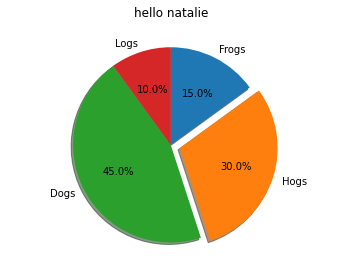

In [50]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("hello natalie  \n")

plt.show()

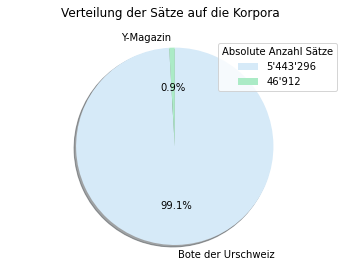

In [60]:
labels = 'Bote der Urschweiz', 'Y-Magazin'
percentages = [99.1, 0.9]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#d6eaf8', '#abebc6']
zahlen = ['5\'443\'296', '46\'912']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Verteilung der Sätze auf die Korpora  \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

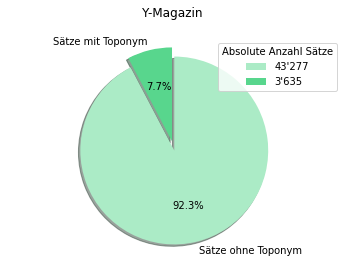

In [55]:
labels = 'Sätze ohne Toponym', 'Sätze mit Toponym'
percentages = [92.3, 7.7]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#abebc6', '#58d68d']
zahlen = ['43\'277', '3\'635']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Y-Magazin \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

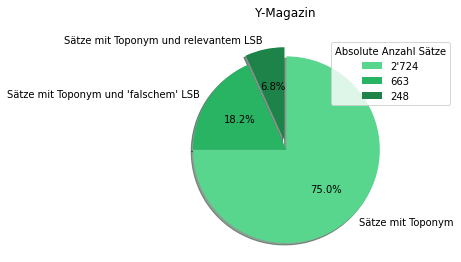

In [56]:
labels = 'Sätze mit Toponym', 'Sätze mit Toponym und \'falschem\' LSB', 'Sätze mit Toponym und relevantem LSB'
percentages = [75, 18.2, 6.8]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#58d68d', '#28b463', '#1d8348']
zahlen = ['2\'724', '663', '248']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Y-Magazin \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

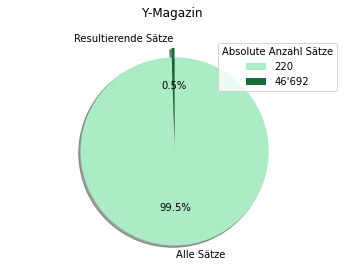

In [57]:
labels = 'Alle Sätze', 'Resultierende Sätze'
percentages = [99.5, 0.5]
explodes = (0, 0.1)  # only "explode" the 2nd slice
colors = ['#abebc6', '#186a3b']
zahlen = ['220', '46\'692']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explodes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Y-Magazin \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

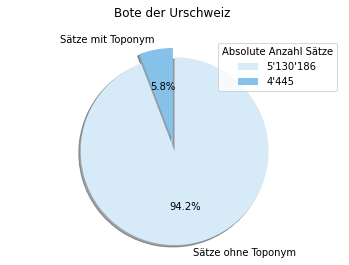

In [61]:
labels = 'Sätze ohne Toponym', 'Sätze mit Toponym'
percentages = [94.2, 5.8]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#d6eaf8', '#85c1e9']
zahlen = ['5\'130\'186', '4\'445']   
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Bote der Urschweiz \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

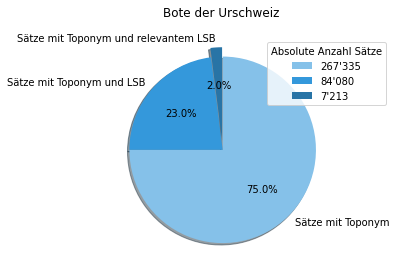

In [10]:
labels = 'Sätze mit Toponym', 'Sätze mit Toponym und \'falschem\' LSB', 'Sätze mit Toponym und relevantem LSB'
percentages = [86.5, 11.9, 1.6]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#85c1e9', '#3498db', '#2874a6']
zahlen = ['270\'836', '37\'369', '4\'905']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Bote der Urschweiz \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

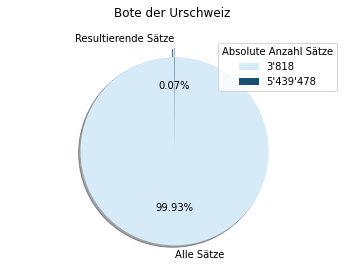

In [59]:
labels = 'Alle Sätze', 'Resultierende Sätze'
percentages = [99.93, 0.07]
explodes = (0, 0.1)  # only "explode" the 2nd slice
colors = ['#d6eaf8', '#1b4f72']
zahlen = ['3\'818', '5\'439\'478']
fig1, ax1 = plt.subplots()
ax1.pie(percentages, explode=explodes, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Bote der Urschweiz \n")
plt.legend(zahlen, loc="best", title='Absolute Anzahl Sätze')

plt.show()

# Cosine Similarity für SG und für Types und LSB

In [4]:
#Converting Text to Numbers
#Term frequency = (Number of Occurrences of a word)/(Total words in the document)
#IDF(word) = Log((Total number of documents)/(Number of documents containing the word))

#with open(r'D:\Natalie\14_analysis\lsk_lsb_in_SG_all.txt') as f:
with open(r'/Users/nb/Desktop/MA/14_analysis/COSSIM/new_lsb/jaccard_sixways.csv') as f:
    text = f.readlines()
    print(len(text))

# tokenize and build vocab
vectorizer = TfidfVectorizer()
vectorizer.fit(text)
# summarize
print("voc", vectorizer.vocabulary_)
print("idf", vectorizer.idf_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

print('cos sim: ',cosine_similarity(vector))

6
voc {'alpwirtschaft': 48, 'wanderweg': 962, 'alp': 10, 'gras': 401, 'grates': 405, 'kloster': 525, 'wanderung': 960, 'turm': 897, 'brücke': 193, 'weiden': 986, 'wilden': 1000, 'felsen': 308, 'gebiet': 368, 'karstgebiet': 515, 'berge': 119, 'blick': 187, 'berglandschaft': 141, 'pisten': 679, 'schlitten': 733, 'natur': 618, 'aussichten': 71, 'tourismus': 887, 'wiesen': 992, 'berg': 113, 'alpen': 18, 'bildstock': 180, 'fischer': 331, 'abendsonne': 1, 'licht': 567, 'ort': 652, 'psalm': 689, 'waldlichtung': 937, 'wolken': 1027, 'sonne': 819, 'tal': 860, 'ufer': 898, 'talkessel': 863, 'aue': 57, 'nebeldecke': 637, 'gipfel': 392, 'see': 758, 'urwald': 908, 'seedamm': 763, 'kuppe': 535, 'staumauerstrasse': 833, 'waldstätte': 946, 'gondelbahn': 399, 'skiregion': 809, 'bergstation': 159, 'kapelle': 512, 'aufstieg': 62, 'landschaft': 546, 'moorlandschaft': 595, 'rebberg': 700, 'eisenbahn': 242, 'ruhe': 716, 'bahn': 88, 'hang': 425, 'senke': 779, 'insel': 490, 'talstation': 865, 'felsformation':

In [12]:
# Converting Text to Numbers
#Term frequency = (Number of Occurrences of a word)/(Total words in the document)
#IDF(word) = Log((Total number of documents)/(Number of documents containing the word))

with open(r'D:\Natalie\14_analysis\COSSIM\new_lsb\kombi_lsb_in_SG.txt') as f:
    text = f.readlines()
    print(len(text))

# tokenize and build vocab
vectorizer = TfidfVectorizer()
vectorizer.fit(text)
# summarize
print("voc", vectorizer.vocabulary_)
print("idf", vectorizer.idf_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

print('cos sim: ',cosine_similarity(vector))
cos_sim = cosine_similarity(vector)

6
voc {'alpgebã': 6, 'ude': 245, 'gebiet': 83, 'wald': 254, 'blick': 50, 'turm': 243, 'sonne': 215, 'bergstation': 41, 'hã¼tte': 115, 'luftseilbahn': 147, 'talstation': 231, 'karstgebiet': 126, 'berge': 36, 'berglandschaft': 40, 'pisten': 175, 'schlitten': 187, 'natur': 160, 'alpen': 5, 'fã': 82, 'hnstã¼rme': 107, 'kã': 132, 'lte': 146, 'schnee': 189, 'mythengebiet': 156, 'landschaften': 135, 'lago': 133, 'tiere': 236, 'wandergebiete': 257, 'schneeschmelze': 191, 'bergen': 37, 'alp': 2, 'stein': 224, 'meer': 152, 'foto': 80, 'seilbahn': 203, 'talkessel': 230, 'lpler': 142, 'landschaft': 134, 'bergtour': 43, 'schlittenhunde': 188, 'kraftwerk': 130, 'see': 198, 'verzweigung': 253, 'feuerstelle': 76, 'tal': 228, 'gebã': 84, 'birken': 49, 'tieren': 237, 'alpauffahrt': 3, 'heuet': 104, 'hochtouren': 112, 'hã': 114, 'lloch': 140, 'wilden': 269, 'gondelbahn': 97, 'grates': 99, 'kloster': 129, 'wanderung': 260, 'morgengrauen': 155, 'platz': 176, 'tier': 235, 'seebrã¼cke': 200, 'eishockey': 65,

In [5]:
cos_sim = cosine_similarity(vector)
for vec in cos_sim:
    print(vec)

[1.         0.5713888  0.38767744 0.39516177 0.04313023 0.06575014]
[0.5713888  1.         0.5244701  0.58520434 0.08585254 0.10731057]
[0.38767744 0.5244701  1.         0.74115569 0.05905957 0.09291841]
[0.39516177 0.58520434 0.74115569 1.         0.08362557 0.13716917]
[0.04313023 0.08585254 0.05905957 0.08362557 1.         0.72405161]
[0.06575014 0.10731057 0.09291841 0.13716917 0.72405161 1.        ]


In [7]:
df = pd.read_csv(r"D:\Natalie\14_analysis\COOC\lsb_combis_botev2_csv.csv", sep=';', encoding='utf-8')
df

,Alp,Unnamed: 1,Alpen,Unnamed: 3,Aussicht,Unnamed: 5,Berg,Unnamed: 7,Blick,Unnamed: 9,...,See,Unnamed: 17,Ski,Unnamed: 19,Skigebiet,Unnamed: 21,Talkessel,Unnamed: 23,Wanderung,Unnamed: 25
0,10,Skilifte,55.0,Blick,11.0,Berge,9.0,See,57.0,Talkessel,...,32.0,Blick,10.0,Skigebiet,96.0,foreveralone,57.0,Blick,5.0,Bahn
1,8,Gebiet,54.0,Talkessel,10.0,See,4.0,Tourismus,55.0,Alpen,...,21.0,Alpenpanorama,3.0,Skiregion,10.0,Ski,54.0,Alpen,4.0,Aussicht
2,6,Mythengebiet,5.0,Aussicht,10.0,Talkessel,3.0,Gemeinde,32.0,See,...,12.0,Berge,3.0,Piste,3.0,Standseilbahn,10.0,Aussicht,4.0,Seilbahn
3,5,Älpler,3.0,Älpler,6.0,Bahnstation,2.0,Aussicht,20.0,Alpenpanorama,...,10.0,Aussicht,2.0,Schneeschuhtour,3.0,Bergdorf,4.0,Nebel,4.0,Landschaft
4,5,Alpkäse,2.0,Kühe,5.0,Alpen,2.0,Skitour,20.0,Mond,...,9.0,Berg,2.0,Bahn,2.0,Bergbeizen,3.0,Licht,3.0,Klettertour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1,Alphütte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,1,Älplerfamilie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,1,Älplerstelle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,1,Berg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cols = [col for col in df]
print(cols)

['Alp', 'Unnamed: 1', 'Alpen', 'Unnamed: 3', 'Aussicht', 'Unnamed: 5', 'Berg', 'Unnamed: 7', 'Blick', 'Unnamed: 9', 'Felsenkapelle', 'Unnamed: 11', 'Landschaft', 'Unnamed: 13', 'Luftseilbahn', 'Unnamed: 15', 'See', 'Unnamed: 17', 'Ski', 'Unnamed: 19', 'Skigebiet', 'Unnamed: 21', 'Talkessel', 'Unnamed: 23', 'Wanderung', 'Unnamed: 25']


In [9]:
lsb_dict = {}
for lsb_name, unnamed in zip(cols[0::2], cols[1::2]):
    lsb_dict[lsb_name] = []
    for index, row in df.iterrows():
        count = row[lsb_name]
        word = row[unnamed]
        if count > 0:
            lsb_dict[lsb_name] += int(count) * [word]
        
for lsb in lsb_dict:
    print(lsb, lsb_dict[lsb])

Alp ['Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Skilifte', 'Gebiet', 'Gebiet', 'Gebiet', 'Gebiet', 'Gebiet', 'Gebiet', 'Gebiet', 'Gebiet', 'Mythengebiet', 'Mythengebiet', 'Mythengebiet', 'Mythengebiet', 'Mythengebiet', 'Mythengebiet', 'Älpler', 'Älpler', 'Älpler', 'Älpler', 'Älpler', 'Alpkäse', 'Alpkäse', 'Alpkäse', 'Alpkäse', 'Alpkäse', 'Dorf', 'Dorf', 'Dorf', 'Dorf', 'Föhn', 'Föhn', 'Föhn', 'Föhn', 'Skilift', 'Skilift', 'Skilift', 'Skilift', 'Bergwelt', 'Bergwelt', 'Bergwelt', 'Gemeinde', 'Gemeinde', 'Gemeinde', 'Höhe', 'Höhe', 'Höhe', 'Alpkäserei', 'Alpkäserei', 'Alpkäserei', 'Seilbahn', 'Seilbahn', 'Seilbahn', 'Matten', 'Matten', 'Matten', 'Passstrasse', 'Passstrasse', 'Gras', 'Gras', 'Fluss', 'Fluss', 'Ort', 'Ort', 'Mond', 'Mond', 'Brücke', 'Brücke', 'Alpen', 'Alpen', 'Bike', 'Bike', 'Talstation', 'Talstation', 'Hof', 'Hof', 'Bergsonne', 'Bergsonne', 'Hotel', 'Hotel', 'Tourismus', 'Tourismus', 'Tal', 'Tal', 'Bergres

## Jaccard Index
### mag-in-SG vs mag-out-SG vs bote-in-SG vs bote-out-SG vs konzept-in-SG vs konzept-in-SG_ext vs all-lsb-in-SG(?)

In [3]:
jaccard =[]
#with open(r'D:\Natalie\14_analysis\lsk_lsb_in_SG_all.txt') as f:
with open(r'/Users/nb/Desktop/MA/14_analysis/COSSIM/new_lsb/jaccard_sixways.csv') as f:
    text = f.readlines()
    print(len(text))
for i in range(len(text)):
    jacci = []
    for j in range(len(text)):       
        a = set(text[i].split()) 
        b = set(text[j].split())
        c = a.intersection(b)
        jacci.append(float(len(c)) / (len(a) + len(b) - len(c)))
        print(jacci)
    jaccard.append(jacci)

jaccard

6
[1.0]
[1.0, 0.25301204819277107]
[1.0, 0.25301204819277107, 0.1]
[1.0, 0.25301204819277107, 0.1, 0.04420549581839905]
[1.0, 0.25301204819277107, 0.1, 0.04420549581839905, 0.060810810810810814]
[1.0, 0.25301204819277107, 0.1, 0.04420549581839905, 0.060810810810810814, 0.05263157894736842]
[0.25301204819277107]
[0.25301204819277107, 1.0]
[0.25301204819277107, 1.0, 0.22023809523809523]
[0.25301204819277107, 1.0, 0.22023809523809523, 0.1497695852534562]
[0.25301204819277107, 1.0, 0.22023809523809523, 0.1497695852534562, 0.06037735849056604]
[0.25301204819277107, 1.0, 0.22023809523809523, 0.1497695852534562, 0.06037735849056604, 0.08029197080291971]
[0.1]
[0.1, 0.22023809523809523]
[0.1, 0.22023809523809523, 1.0]
[0.1, 0.22023809523809523, 1.0, 0.2932692307692308]
[0.1, 0.22023809523809523, 1.0, 0.2932692307692308, 0.058997050147492625]
[0.1, 0.22023809523809523, 1.0, 0.2932692307692308, 0.058997050147492625, 0.09433962264150944]
[0.04420549581839905]
[0.04420549581839905, 0.1497695852534

[[1.0,
  0.25301204819277107,
  0.1,
  0.04420549581839905,
  0.060810810810810814,
  0.05263157894736842],
 [0.25301204819277107,
  1.0,
  0.22023809523809523,
  0.1497695852534562,
  0.06037735849056604,
  0.08029197080291971],
 [0.1,
  0.22023809523809523,
  1.0,
  0.2932692307692308,
  0.058997050147492625,
  0.09433962264150944],
 [0.04420549581839905,
  0.1497695852534562,
  0.2932692307692308,
  1.0,
  0.04065934065934066,
  0.08610567514677103],
 [0.060810810810810814,
  0.06037735849056604,
  0.058997050147492625,
  0.04065934065934066,
  1.0,
  0.4136690647482014],
 [0.05263157894736842,
  0.08029197080291971,
  0.09433962264150944,
  0.08610567514677103,
  0.4136690647482014,
  1.0]]

## Unique LSB pro Schlüsselgebiet

In [14]:
unique_lsb_in_SG = {}

with open(r'D:\Natalie\14_analysis\lsk_lsb_in_SG_all.txt') as f:
    text = f.readlines()
    
for i in range(len(text)):
    bag_of_lsb=[]
    for j in range(len(text)):
        if i != j:
            bag_of_lsb_temp = text[j].split()
            bag_of_lsb += (bag_of_lsb_temp)

    lsb_in_SG_temp = text[i].split()
    lsb_in_SG_temp = list(set(lsb_in_SG_temp))
    lsb_list_temp = []
    for lsb in lsb_in_SG_temp:
        if lsb not in bag_of_lsb:
            lsb_list_temp.append(lsb)
            unique_lsb_in_SG[i] = lsb_list_temp 


In [132]:
unique_lsb_per_types = {}

with open(r'D:\Natalie\14_analysis\kombi_lsb_per_type.txt') as f:
    text = f.readlines()
    
for i in range(len(text)):
    bag_of_lsb=[]
    for j in range(len(text)):
        if i != j:
            bag_of_lsb_temp = text[j].split()
            bag_of_lsb += (bag_of_lsb_temp)

    lsb_in_SG_temp = text[i].split()
    lsb_in_SG_temp = list(set(lsb_in_SG_temp))
    lsb_list_temp = []
    for lsb in lsb_in_SG_temp:
        if lsb not in bag_of_lsb:
            lsb_list_temp.append(lsb)
            unique_lsb_per_types[i] = lsb_list_temp 

In [16]:
unique_lsb_in_SG

{0: ['Alpbetriebe',
  'Gebirgszüge',
  'Moorlandschaft',
  'ErholungspotenzialNatur',
  'Faune',
  'Hochtal',
  'Turm',
  'Karrfelder',
  'Verebnungsfläche',
  'Karstlandschaft',
  'Gebirgslandschaft',
  'Polje'],
 1: ['Tierarten',
  'Reservat',
  'Habitaten',
  'Erholungswert',
  'Berglandschaft',
  'Alpenpflanzen',
  'Artenvielfalt',
  'Pflanzenschutzreservate',
  'Habitate',
  'Köpfengebiet',
  'Weidegebiete',
  'Alpenraumes',
  'Pflanzen',
  'Landschaftsstruktur',
  'Inseln',
  'Fauna'],
 2: ['Tal',
  'Naturraum',
  'Wildheuen',
  'Wildheuflächen4Hanglage',
  'Einzelhöfen',
  'Verkehrsinfrastrukturlandschaft',
  'Gebäude',
  'Naturprozessen'],
 3: ['Einzelhöfe',
  'Moorige',
  'Klippen',
  'Pflanzenschutzreservat',
  'Biotop',
  'Kapellen',
  'Felspartien',
  'Landschaftsansich',
  'Natur',
  'Naturerlebniswert',
  'Landschaftsschutz',
  'Naherholung',
  'Talkessel',
  'Identifikationslandschaft',
  'Flysch-Landschaft',
  'Wald-Offenland',
  'Pflanzenschutzgebiet',
  'Jakobsweges',

# Word Clouds

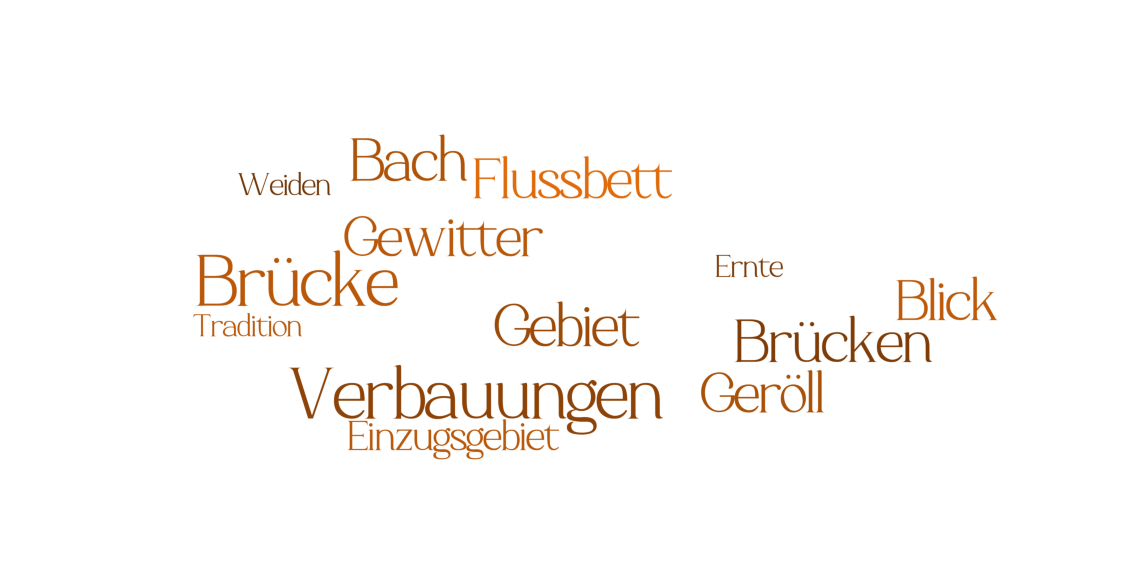

In [136]:
wordlist = []

with open('/Users/nb/Desktop/MA/12_plots/wordclouds/word_files/lsb_SG6.csv', 'r') as f:
    reader = csv.reader(f)
    wordlist = '\t'.join([i[0] for i in reader])

width = 6000
height = 3000
    
#Shape: Kanton SZ
mask = np.array(Image.open('/Users/nb/Desktop/MA/12_plots/wordclouds/Karte-Schwyz-e1602250876673.png'))
#Shape: Oval
mask = np.array(Image.open('/Users/nb/Desktop/MA/12_plots/wordclouds/thatshirt-t-shir.jpg').resize((width, height), Image.BICUBIC))

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path='/Users/nb/Desktop/MA/12_plots/wordclouds/Luimp Light.otf', random_state=None):
    h = 27 #int(360.0 * 21.0 / 255.0)
    s = 91 #int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
    
# Generate a word cloud image
wordcloud = WordCloud(
    repeat=False, 
    font_path='/Users/nb/Desktop/MA/12_plots/wordclouds/Luimp.otf', 
    background_color='white', 
    collocations=False,
    mask=mask, 
    width=width, 
    height=height
).generate(wordlist)
wordcloud.recolor(color_func=random_color_func, random_state=3)
wordcloud.to_file("lsb_SG6.pdf")


plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


# Bar Charts

In [15]:
filename = "/Users/nb/Desktop/MA/14_analysis/bar_charts_topo_2.csv"

In [16]:
df = pd.read_csv(filename, sep="\t", encoding='utf-8')

In [17]:
df

,Name,Mag sel,Mag all,Bote sel,Bote all
0,Rigi,9.567901,4.409912,7.648309,1.882675
1,Muotatal,7.716049,2.855943,2.941657,3.203338
2,Gross Mythen,5.864198,0.587988,4.575911,0.731800
3,Stoos,4.629630,0.734985,6.030397,0.925280
4,Schwyz,4.012346,24.653507,5.915999,20.698896
5,Gersau,3.086420,3.254935,2.271613,1.955592
6,Einsiedeln,3.086420,5.732885,1.307403,2.807165
7,Glattalp,1.851852,0.272995,2.495108,0.153204
8,Muota,1.851852,0.272995,2.500409,0.153204
9,Goldau,1.543210,0.104998,0.490276,2.817695


[Text(0, 0, 'Rigi'),
 Text(1, 0, 'Muotatal'),
 Text(2, 0, 'Gross Mythen'),
 Text(3, 0, 'Stoos'),
 Text(4, 0, 'Schwyz'),
 Text(5, 0, 'Gersau'),
 Text(6, 0, 'Einsiedeln'),
 Text(7, 0, 'Glattalp'),
 Text(8, 0, 'Muota'),
 Text(9, 0, 'Goldau'),
 Text(10, 0, 'Bödmeren'),
 Text(11, 0, 'Wägital'),
 Text(12, 0, 'Sihlsee'),
 Text(13, 0, 'Pragelpass'),
 Text(14, 0, 'Wägitalersee')]

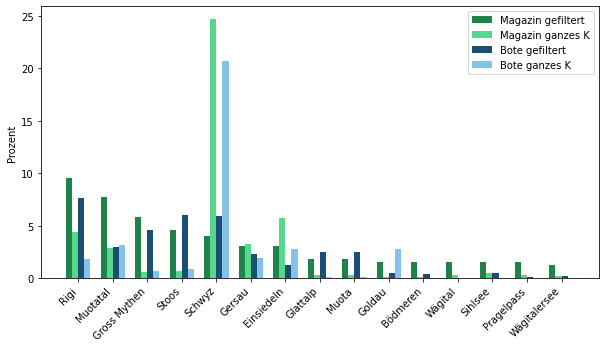

In [20]:
# df = df.sort_values("Bote sel",ascending=False) 
x = np.arange(df.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - 3*width/4, df["Mag sel"], width/2, label='Magazin gefiltert', color='#1d8348')
rects2 = ax.bar(x - width/4, df["Mag all"], width/2, label='Magazin ganzes K', color='#58d68d')
rects3 = ax.bar(x + width/4, df["Bote sel"], width/2, label='Bote gefiltert', color='#1b4f72')
rects4 = ax.bar(x + 3*width/4, df["Bote all"], width/2, label='Bote ganzes K', color="#85c1e9")
ax.set_ylabel("Prozent")
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(df["Name"],rotation=45, ha="right")


In [3]:
filename = "/Users/nb/Desktop/MA/14_analysis/bar_charts_lsb.csv"
filename = "/Users/nb/Desktop/MA/14_analysis/bar_charts_lsb_SG_in_out.csv"
df = pd.read_csv(filename, sep="\t", encoding='utf-8')
df

,LSB,outside SG,inside SG
0,Alp,4.877588,2.219140
1,Blick,3.496129,4.022191
2,Talkessel,2.923406,3.051318
3,Wanderung,2.747184,0.970874
4,See,2.227956,2.219140
5,Ski,1.960476,0.970874
6,Luftseilbahn,1.941595,0.832178
7,Alpen,1.538800,1.803051
8,Gebiet,1.337403,1.386963
9,Berg,1.327963,0.970874


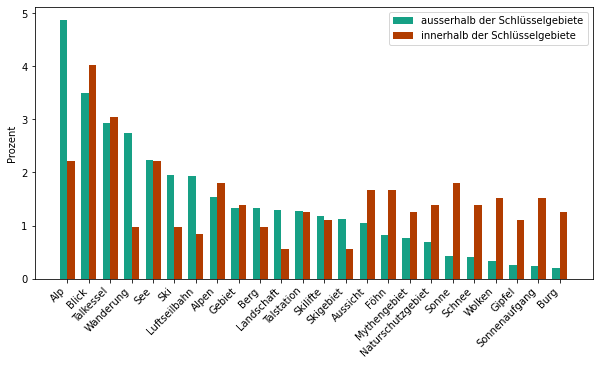

In [15]:
# df = df.sort_values("Bote sel",ascending=False) 
x = np.arange(df.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, df["outside SG"], width, label='ausserhalb der Schlüsselgebiete', color='#16a085')#a2d9ce')
rects2 = ax.bar(x + width/2, df["inside SG"], width, label='innerhalb der Schlüsselgebiete', color='#B13C00')#743000 #943C00

ax.set_ylabel("Prozent")
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(df["LSB"],rotation=45, ha="right")
plt.savefig('lsb_bar_chart.pdf')

[Text(0, 0, 'Blick'),
 Text(1, 0, 'Alp'),
 Text(2, 0, 'Talkessel'),
 Text(3, 0, 'Wanderung'),
 Text(4, 0, 'See'),
 Text(5, 0, 'Ski'),
 Text(6, 0, 'Alpen'),
 Text(7, 0, 'Skigebiet'),
 Text(8, 0, 'Luftseilbahn'),
 Text(9, 0, 'Landschaft'),
 Text(10, 0, 'Aussicht'),
 Text(11, 0, 'Felsenkapelle'),
 Text(12, 0, 'Berg'),
 Text(13, 0, 'Berge'),
 Text(14, 0, 'Tal'),
 Text(15, 0, 'Sonne'),
 Text(16, 0, 'Kloster'),
 Text(17, 0, 'Wiesen'),
 Text(18, 0, 'Wolken'),
 Text(19, 0, 'Gipfel')]

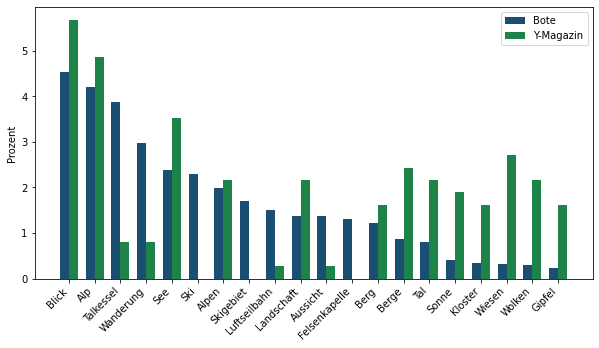

In [27]:
# df = df.sort_values("Bote sel",ascending=False) 
x = np.arange(df.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, df["bote"], width, label='Bote', color='#1b4f72')
rects2 = ax.bar(x + width/2, df["magazin"], width, label='Y-Magazin', color='#1d8348')

ax.set_ylabel("Prozent")
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(df["lsb"],rotation=45, ha="right")
